In [1]:
from google.colab import drive
import tarfile
import keras
import os,shutil, pickle
from keras import layers
from keras import models
from keras.models import Model
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization, Flatten
from keras import optimizers
from keras.utils import np_utils
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [2]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError: # If TPU not found
  tpu = None

# Select appropriate distribution strategy
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
else:
  tpu_strategy = tf.distribute.get_strategy() # Default strategy that works on CPU and single GPU
  print('Running on CPU instead')
print("Number of accelerators: ", tpu_strategy.num_replicas_in_sync)  

Running on TPU  ['10.23.232.170:8470']
Number of accelerators:  8


In [3]:
def pre_trained_isolated_model():
    input = tf.keras.Input(shape=(32,32,3))
    efnet = tf.keras.applications.ResNet50(weights='imagenet',
                                                include_top = False, 
                                                input_tensor = input)
    # Now that we apply global max pooling.
    gap = tf.keras.layers.GlobalMaxPooling2D()(efnet.output)

    # Finally, we add a classification layer.
    output = tf.keras.layers.Dense(10, activation='softmax')(gap)

    # bind all
    model = tf.keras.Model(efnet.input, output)
    model.compile(
            loss  = tf.keras.losses.CategoricalCrossentropy(),
            metrics = tf.keras.metrics.CategoricalAccuracy(),
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001))

    return model

In [8]:
from keras.datasets import cifar10
import random

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = tf.keras.utils.to_categorical(y_train , num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test , num_classes=10)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)


In [5]:
# from keras.datasets.cifar10 import load_data

# # load and prepare cifar10 training images
# def load_real_samples():
# 	# load cifar10 dataset
# 	(trainX, _), (_, _) = load_data()
# 	# convert from unsigned ints to floats
# 	X = trainX.astype('float32')
# 	# scale from [0,255] to [-1,1]
# 	X = (X - 127.5) / 127.5
# 	return X

In [6]:
# x_train = load_real_samples()

In [9]:
with tpu_strategy.scope():
  #create isolated model: a pretrained classification model on mnist
  isolated_model = pre_trained_isolated_model()

  history = isolated_model.fit(x_train, y_train, 
                      batch_size=128, epochs=30,
                      validation_split=0.2)

Epoch 1/30
313/313 [==============================] - 109s 158ms/step - loss: 2.8296 - categorical_accuracy: 0.1801 - val_loss: 78.4453 - val_categorical_accuracy: 0.0951
Epoch 2/30
313/313 [==============================] - 18s 57ms/step - loss: 2.1416 - categorical_accuracy: 0.3195 - val_loss: 57.9695 - val_categorical_accuracy: 0.0826
Epoch 3/30
313/313 [==============================] - 17s 54ms/step - loss: 1.8718 - categorical_accuracy: 0.3920 - val_loss: 3.0612 - val_categorical_accuracy: 0.2554
Epoch 4/30
313/313 [==============================] - 16s 51ms/step - loss: 1.7060 - categorical_accuracy: 0.4426 - val_loss: 1.8087 - val_categorical_accuracy: 0.4554
Epoch 5/30
313/313 [==============================] - 17s 54ms/step - loss: 1.5845 - categorical_accuracy: 0.4754 - val_loss: 1.6696 - val_categorical_accuracy: 0.4841
Epoch 6/30
313/313 [==============================] - 15s 49ms/step - loss: 1.4883 - categorical_accuracy: 0.5046 - val_loss: 1.5748 - val_categorical_accur

In [10]:
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
model_path = "/content/drive/MyDrive/"
isolated_model.save(model_path+"Resnet50_isolated_model_30epoch_cifar10.h5")

In [14]:
import matplotlib.pyplot as plt

def train_val_by_metric(history,metric):
  history_dict = history.history
  #history_dict.keys()
  values = history_dict[metric]
  val_values = history_dict['val_'+metric]

  epochs = range(1, len(values) + 1)
  
  plt.plot(epochs, values, 'bo', label= 'Training '+metric)
  plt.plot(epochs, val_values, 'b', label= 'Validation '+metric)
  metricTitle = 'Loss' if metric == 'loss' else 'Accuracy'
  plt.title('Training and validation '+metricTitle)
  plt.xlabel('Epochs')
  plt.ylabel(metricTitle)
  plt.legend()
  fig_name = 'Resnet50_isolated_model_30epoch_cifar10' + metric + '.pdf'
  model_path = "/content/drive/MyDrive/"
  plt.savefig(model_path+fig_name, format="pdf", bbox_inches="tight")
  plt.show()
  
###################################################

def train_val_plot(history):
  train_val_by_metric(history,'loss')
  train_val_by_metric(history,'categorical_accuracy')

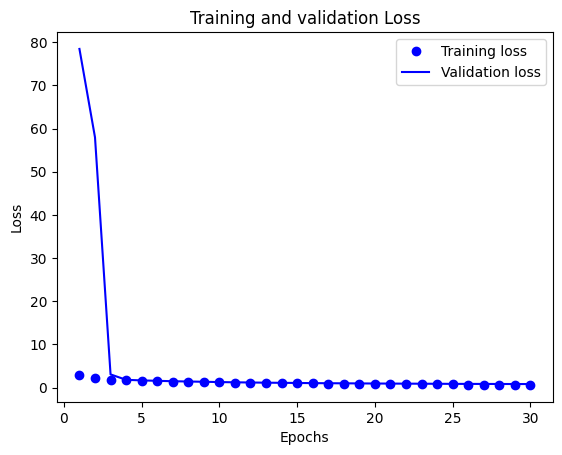

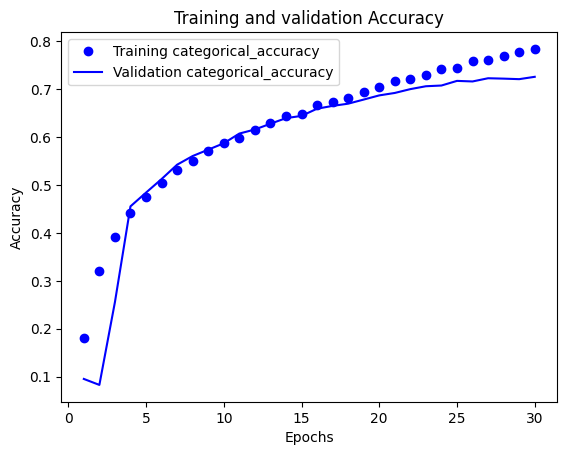

In [15]:
train_val_plot(history)